In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import networkx as nx
import matplotlib.pyplot as plt
import kkyao as kk
import MetaTrader5 as mt5

# Connect to MT5
mt5.initialize()


True

In [43]:
stock1 = 'AMBANK'
stock2 = 'RHBBANK'
stock3 = 'CIMB'
stock4 = 'MAYBANK'


stocks = [stock1, stock2, stock3, stock4]
time_frame = mt5.TIMEFRAME_M10
endBar = 1
n_datapoint = 2000

df1 = kk.download_mt5_data(stock1, time_frame, endBar, n_datapoint)
df2 = kk.download_mt5_data(stock2, time_frame, endBar, n_datapoint)
df3 = kk.download_mt5_data(stock3, time_frame, endBar, n_datapoint)
df4 = kk.download_mt5_data(stock4, time_frame, endBar, n_datapoint)

# compile Close price from all stocks
data = pd.DataFrame()
data[f'{stock1}'] = df1['Close']
data[f'{stock2}'] = df2['Close']
data[f'{stock3}'] = df3['Close']
data[f'{stock4}'] = df4['Close']
data


,AMBANK,RHBBANK,CIMB,MAYBANK
Date,,,,
2023-05-12 11:10:00,3.53,5.49,4.98,8.76
2023-05-12 11:20:00,3.52,5.50,4.97,8.77
2023-05-12 11:30:00,3.52,5.50,4.99,8.77
2023-05-12 11:40:00,3.53,5.50,4.97,8.76
2023-05-12 11:50:00,3.53,5.49,4.99,8.76
...,...,...,...,...
2023-08-02 16:00:00,3.76,5.65,5.48,8.94
2023-08-02 16:10:00,3.77,5.65,5.48,8.95
2023-08-02 16:20:00,3.76,5.65,5.47,8.95


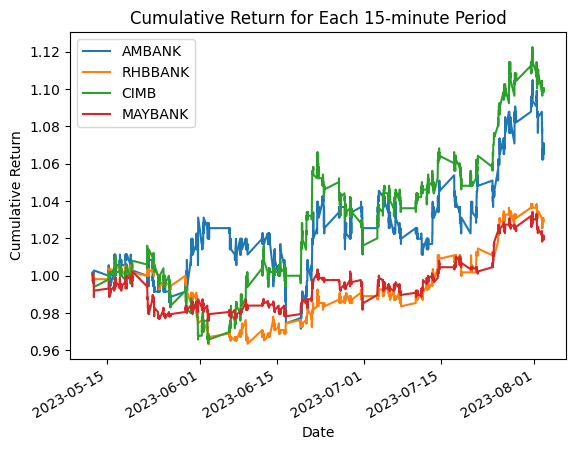

In [44]:
# Calculate percentage change, add 1 and then calculate cumulative product
df_cumprod = (data.pct_change() + 1).cumprod()

# Plot
df_cumprod.plot()
plt.title('Cumulative Return for Each 15-minute Period')
plt.ylabel('Cumulative Return')
plt.show()

In [48]:
#forward fill na values
data = data.fillna(method='ffill')


c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

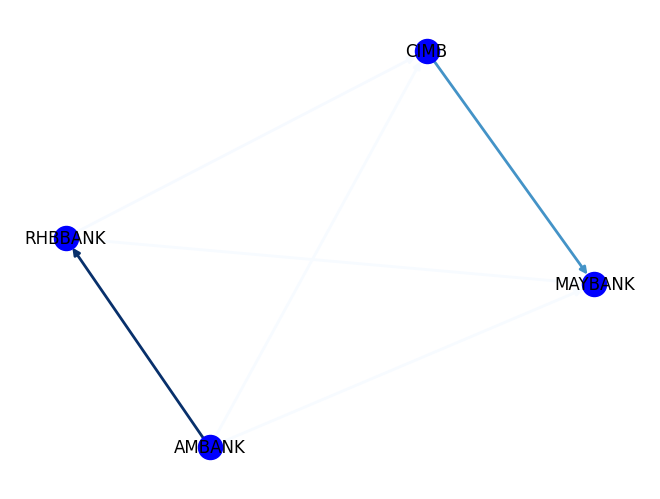

In [58]:
maxlag = 50
test = 'ssr_chi2test'
edges = []

for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
        test_result = grangercausalitytests(data[[stocks[i], stocks[j]]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[k+1][0][test][1],4) for k in range(maxlag)]
        min_p_value = np.min(p_values)
        if min_p_value < 0.05:
            edges.append((stocks[i], stocks[j], min_p_value))


G = nx.DiGraph()
G.add_nodes_from(stocks)
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos = nx.spring_layout(G)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, node_color='blue', edgelist=G.edges(), edge_color=weights, width=2, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()


c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

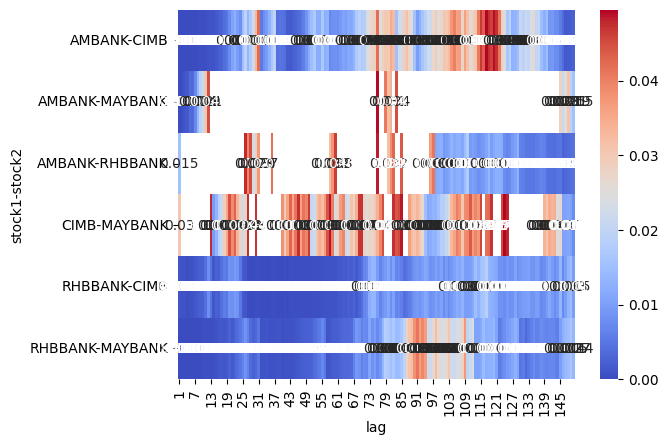

In [62]:
import pandas as pd
import seaborn as sns

maxlag = 150
test = 'ssr_chi2test'
lag_p_values = []

for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
        test_result = grangercausalitytests(data[[stocks[i], stocks[j]]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[k+1][0][test][1],4) for k in range(maxlag)]
        for lag, p_value in enumerate(p_values, start=1):
            if p_value < 0.05:
                lag_p_values.append({
                    'stock1': stocks[i],
                    'stock2': stocks[j],
                    'lag': lag,
                    'p_value': p_value
                })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(lag_p_values)

# Create a multi-index using 'stock1' and 'stock2'
df.set_index(['stock1', 'stock2'], inplace=True)

# Pivot the DataFrame using the multi-index and 'lag' as columns
pivot_df = df.pivot(columns='lag', values='p_value')

# Plot the heatmap
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', cbar=True)
plt.show()


c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\jeffnsy\Desktop\Python codes\rolling_mpt\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

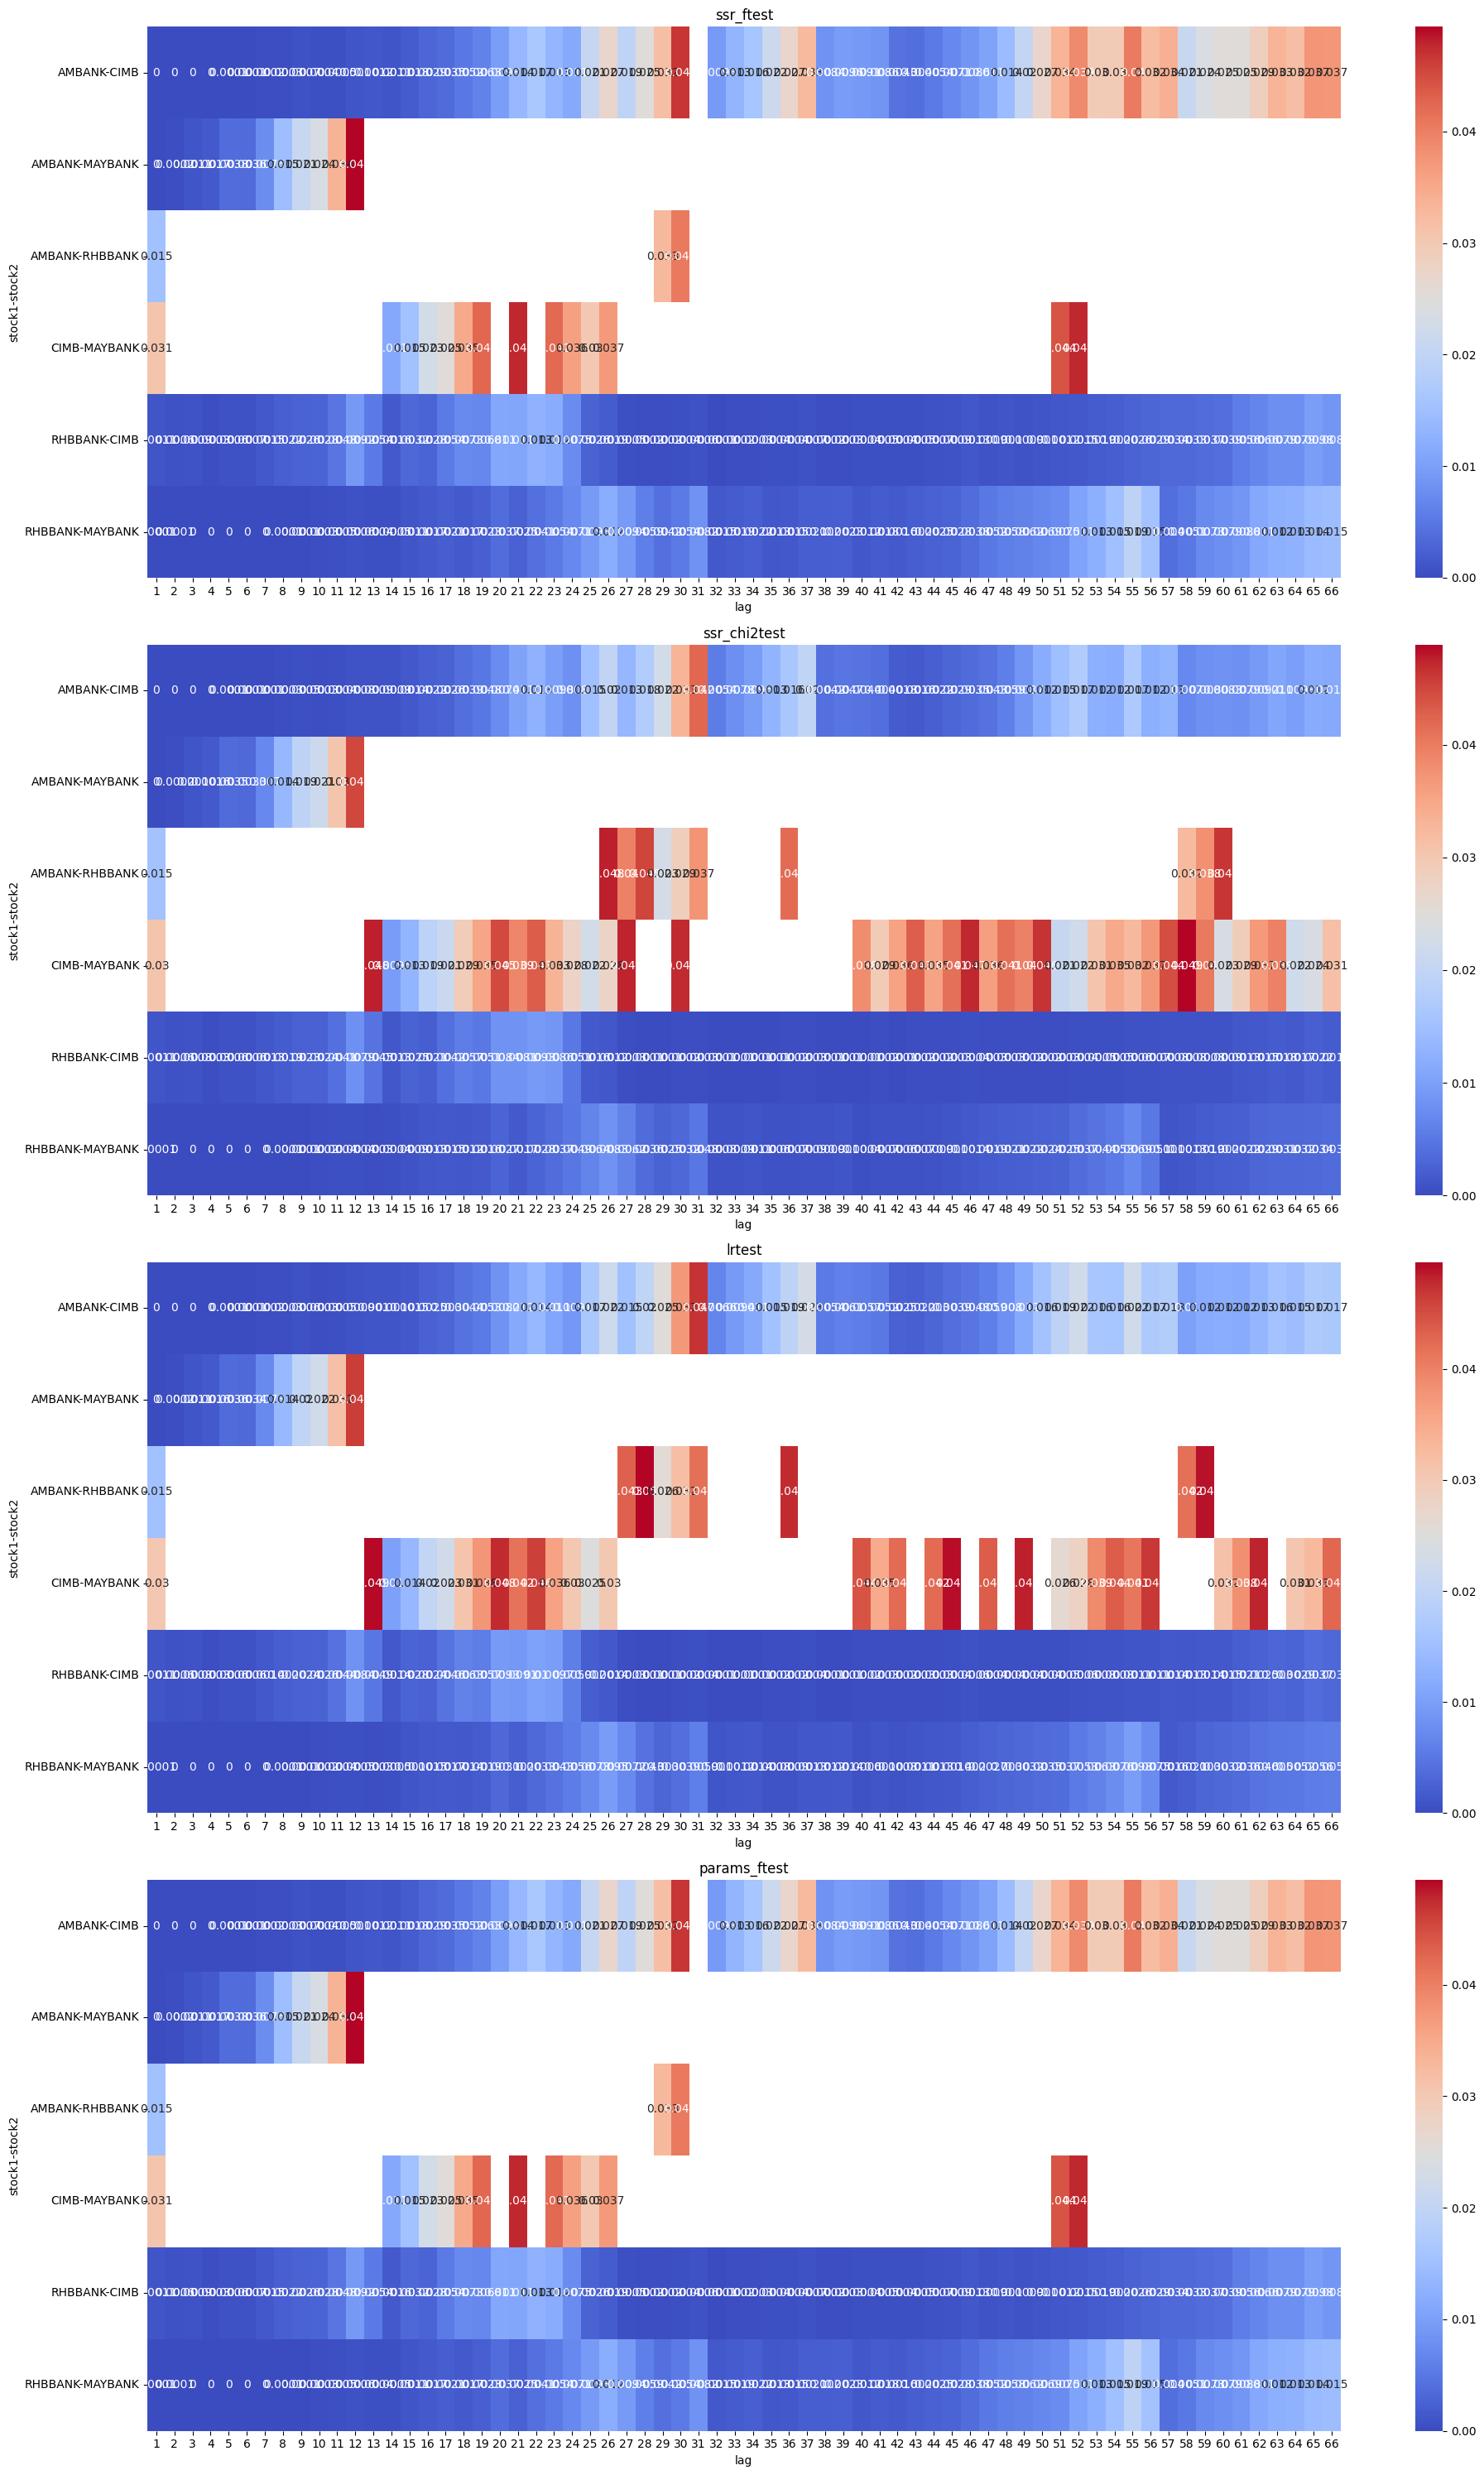

In [67]:
import matplotlib.pyplot as plt

maxlag = 66
tests = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']

fig, axes = plt.subplots(4, 1, figsize=(20, 30))

for ax, test in zip(axes.flatten(), tests):
    lag_p_values = []

    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            test_result = grangercausalitytests(data[[stocks[i], stocks[j]]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[k+1][0][test][1],4) for k in range(maxlag)]
            for lag, p_value in enumerate(p_values, start=1):
                if p_value < 0.05:
                    lag_p_values.append({
                        'stock1': stocks[i],
                        'stock2': stocks[j],
                        'lag': lag,
                        'p_value': p_value
                    })

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(lag_p_values)

    # Create a multi-index using 'stock1' and 'stock2'
    df.set_index(['stock1', 'stock2'], inplace=True)

    # Pivot the DataFrame using the multi-index and 'lag' as columns
    pivot_df = df.pivot(columns='lag', values='p_value')

    # Plot the heatmap
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', cbar=True, ax=ax)
    ax.set_title(test)

plt.tight_layout()
plt.show()
